<!-- # Climbing Hold Detection - SAM (Segment Anything Model) Training

This notebook trains SAM (Segment Anything Model) on your climbing hold annotations.

## What is SAM?
- **Segment Anything Model (SAM)** by Meta AI - a powerful segmentation model
- Can segment objects from prompts (points, boxes, masks)
- We'll fine-tune it specifically for climbing hold detection using your annotations

## What this notebook does:
1. **Loads your COCO format annotations** from `data/annotations/`
2. **Prepares the dataset** for SAM training
3. **Fine-tunes SAM** on your climbing hold images
4. **Evaluates** the trained model
5. **Provides inference** functions to detect holds in new images -->


In [1]:
# Install required packages for SAM training
# Uncomment to install if needed
%pip install segment-anything
%pip install torch torchvision
%pip install opencv-python
%pip install pycocotools
%pip install matplotlib numpy tqdm


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [28]:
import sys
import os
import json
import numpy as np
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Check if segment_anything is installed
try:
    from segment_anything import sam_model_registry, SamPredictor
    from segment_anything.modeling import Sam
    from segment_anything.utils.transforms import ResizeLongestSide
    SAM_AVAILABLE = True
    print("✓ segment-anything installed!")
except ImportError as e:
    SAM_AVAILABLE = False
    print("⚠ segment-anything not installed!")
    print(f"  Error: {e}")
    print("  Install with: pip install segment-anything")
    print("  Make sure you're using the correct kernel (venv)")

print(f"\nPython version: {sys.version}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

✓ segment-anything installed!

Python version: 3.11.10 (main, Sep  7 2024, 19:02:57) [Clang 14.0.0 (clang-1400.0.29.202)]
PyTorch version: 2.9.1
CUDA available: False


In [29]:
# Set paths to your data
BASE_DIR = Path("/Users/eden2025/MSAIF25/ml_project_msai")
IMAGES_DIR = BASE_DIR / "data" / "images"
ANNOTATIONS_DIR = BASE_DIR / "data" / "annotations"

# Use the combined annotations file, or combine them first
ANNOTATION_FILE = ANNOTATIONS_DIR / "holds.json"

# If holds.json doesn't exist, we'll combine the individual annotation files
if not ANNOTATION_FILE.exists():
    print(f"⚠ {ANNOTATION_FILE} not found. Combining individual annotation files...")
    # Combine annotations
    annotation_files = sorted(ANNOTATIONS_DIR.glob("hold_annotations*.json"))
    if annotation_files:
        all_images = []
        all_annotations = []
        categories = None
        img_id_offset = 0
        ann_id_offset = 0
        
        for ann_file in annotation_files:
            with open(ann_file, 'r') as f:
                data = json.load(f)
            
            if categories is None:
                categories = data['categories']
            
            for img in data['images']:
                img['id'] += img_id_offset
                all_images.append(img)
            
            for ann in data['annotations']:
                ann['id'] += ann_id_offset
                ann['image_id'] += img_id_offset
                all_annotations.append(ann)
            
            img_id_offset = max([img['id'] for img in all_images], default=0) + 1
            ann_id_offset = max([a['id'] for a in all_annotations], default=0) + 1
        
        merged_data = {
            'images': all_images,
            'annotations': all_annotations,
            'categories': categories
        }
        
        with open(ANNOTATION_FILE, 'w') as f:
            json.dump(merged_data, f)
        print(f"✓ Combined annotations saved to {ANNOTATION_FILE}")
    else:
        print("⚠ No annotation files found!")
else:
    print(f"✓ Found annotation file: {ANNOTATION_FILE}")

# Load annotations
with open(ANNOTATION_FILE, 'r') as f:
    coco_data = json.load(f)

print(f"\nDataset Summary:")
print(f"  Images: {len(coco_data['images'])}")
print(f"  Annotations: {len(coco_data['annotations'])}")
print(f"  Categories: {len(coco_data['categories'])}")
print(f"  Category names: {[cat['name'] for cat in coco_data['categories']]}")


✓ Found annotation file: /Users/eden2025/MSAIF25/ml_project_msai/data/annotations/holds.json

Dataset Summary:
  Images: 65
  Annotations: 1605
  Categories: 12
  Category names: ['V0', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'UNLABELED']


In [30]:
def detect_holds_polygons(image_path, min_area=300, max_area=30000, 
                          saturation_threshold=60, value_threshold=80,
                          exclude_bottom_percent=15):
    """
    Detect climbing holds in an image using improved computer vision techniques.
    NO ANNOTATIONS OR TRAINING DATA REQUIRED!
    
    Parameters:
    - image_path: Path to the image file
    - min_area: Minimum area for a hold (in pixels)
    - max_area: Maximum area for a hold (in pixels)
    - saturation_threshold: Minimum saturation for colored regions (higher = more vibrant colors)
    - value_threshold: Minimum brightness value (higher = brighter objects)
    - exclude_bottom_percent: Percentage of bottom image to exclude (to filter out floor)
    
    Returns:
    - List of polygons, where each polygon is a list of [x, y] coordinates
    """
    # Read the image
    img = cv2.imread(str(image_path))
    if img is None:
        print(f"Warning: Could not read {image_path}")
        return []
    
    original_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = original_img.shape[:2]
    
    # Create mask to exclude bottom portion (floor region)
    floor_exclude_mask = np.ones((h, w), dtype=np.uint8) * 255
    floor_cutoff = int(h * (1 - exclude_bottom_percent / 100))
    floor_exclude_mask[floor_cutoff:, :] = 0
    
    # Convert to HSV for better color segmentation
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # Method 1: Color-based segmentation - holds are vibrant colors
    # Higher saturation threshold to get more vibrant colors
    lower_color = np.array([0, saturation_threshold, value_threshold])
    upper_color = np.array([180, 255, 255])
    color_mask = cv2.inRange(img_hsv, lower_color, upper_color)
    
    # Apply floor exclusion to color mask
    color_mask = cv2.bitwise_and(color_mask, floor_exclude_mask)
    
    # Method 2: Edge detection with better parameters
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (7, 7), 0)
    edges = cv2.Canny(blurred, 80, 200)
    
    # Only use edges that overlap with colored regions (holds have both color and edges)
    edges = cv2.bitwise_and(edges, color_mask)
    edges = cv2.bitwise_and(edges, floor_exclude_mask)
    
    # Combine color and edge detection (both must be present)
    combined_mask = cv2.bitwise_or(color_mask, edges)
    
    # Morphological operations to clean up and fill gaps
    kernel_close = np.ones((9, 9), np.uint8)
    kernel_open = np.ones((5, 5), np.uint8)
    combined_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_CLOSE, kernel_close)
    combined_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_OPEN, kernel_open)
    
    # Find contours
    contours, _ = cv2.findContours(combined_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    polygons = []
    for contour in contours:
        area = cv2.contourArea(contour)
        
        # Filter by area
        if min_area < area < max_area:
            # Get bounding box and properties
            x, y, w_box, h_box = cv2.boundingRect(contour)
            aspect_ratio = w_box / h_box if h_box > 0 else 0
            
            # Calculate circularity (how round the shape is)
            perimeter = cv2.arcLength(contour, True)
            if perimeter > 0:
                circularity = 4 * np.pi * area / (perimeter * perimeter)
            else:
                circularity = 0
            
            # Calculate solidity (area / convex hull area)
            hull = cv2.convexHull(contour)
            hull_area = cv2.contourArea(hull)
            solidity = area / hull_area if hull_area > 0 else 0
            
            # Filter by location (exclude bottom region)
            center_y = y + h_box // 2
            if center_y > floor_cutoff:
                continue
            
            # Filter by aspect ratio (holds are roughly circular/oval, not too elongated)
            if not (0.3 < aspect_ratio < 3.5):
                continue
            
            # Filter by circularity (holds are somewhat round)
            if circularity < 0.3:
                continue
            
            # Filter by solidity (holds are relatively solid, not too concave)
            if solidity < 0.7:
                continue
            
            # Simplify polygon
            epsilon = 0.01 * cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, epsilon, True)
            
            # Convert to list of [x, y] coordinates
            polygon = [[int(point[0][0]), int(point[0][1])] for point in approx]
            if len(polygon) >= 3:  # Valid polygon
                polygons.append(polygon)
    
    return polygons


In [31]:
# Helper functions to process COCO annotations for SAM
try:
    import pycocotools.mask as mask_util
    PYCOCOTOOLS_AVAILABLE = True
except ImportError:
    PYCOCOTOOLS_AVAILABLE = False
    print("⚠ pycocotools not installed. Install with: pip install pycocotools")

def decode_coco_segmentation(seg, height, width):
    """
    Decode COCO segmentation (polygon or RLE) to binary mask.
    Returns: binary mask (numpy array)
    """
    if isinstance(seg, dict):
        # RLE format - need to convert using frPyObjects first
        if PYCOCOTOOLS_AVAILABLE:
            try:
                # Convert RLE dict to format pycocotools expects
                rle = mask_util.frPyObjects(seg, height, width)
                mask = mask_util.decode(rle)
                if len(mask.shape) == 3:
                    mask = mask[:, :, 0]
                return mask.astype(bool)
            except Exception as e:
                print(f"⚠ Error decoding RLE: {e}")
                return None
        else:
            print("⚠ pycocotools needed for RLE decoding")
            return None
    elif isinstance(seg, list):
        # Polygon format [x1, y1, x2, y2, ...]
        if len(seg) < 6:  # Need at least 3 points
            return None
        
        # Create mask from polygon
        polygon = np.array(seg, dtype=np.int32).reshape(-1, 2)
        mask = np.zeros((height, width), dtype=np.uint8)
        cv2.fillPoly(mask, [polygon], 255)
        return mask.astype(bool)
    return None

def get_bbox_from_mask(mask):
    """Get bounding box from binary mask."""
    y_coords, x_coords = np.where(mask)
    if len(x_coords) == 0:
        return None
    x_min, x_max = int(x_coords.min()), int(x_coords.max())
    y_min, y_max = int(y_coords.min()), int(y_coords.max())
    return [x_min, y_min, x_max - x_min, y_max - y_min]

def get_center_point_from_mask(mask):
    """Get center point from binary mask for SAM prompt."""
    y_coords, x_coords = np.where(mask)
    if len(x_coords) == 0:
        return None
    center_x = int(np.mean(x_coords))
    center_y = int(np.mean(y_coords))
    return [center_x, center_y]

print("✓ Helper functions defined")


✓ Helper functions defined


In [33]:
# Create a PyTorch Dataset for SAM training
class SAMClimbingHoldsDataset(Dataset):
    """
    Dataset class for SAM training on climbing holds.
    Loads COCO format annotations and converts them to SAM format.
    """
    def __init__(self, coco_data, images_dir, transform=None):
        self.coco_data = coco_data
        self.images_dir = Path(images_dir)
        self.transform = transform
        
        # Create mapping from image_id to annotations
        self.image_to_anns = {}
        for ann in coco_data['annotations']:
            img_id = ann['image_id']
            if img_id not in self.image_to_anns:
                self.image_to_anns[img_id] = []
            self.image_to_anns[img_id].append(ann)
        
        # Filter images that have annotations
        self.images = [img for img in coco_data['images'] 
                      if img['id'] in self.image_to_anns]
        
        print(f"✓ Dataset initialized with {len(self.images)} images")
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image_info = self.images[idx]
        image_id = image_info['id']
        
        # Load image
        image_path = self.images_dir / image_info['file_name']
        image = cv2.imread(str(image_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        h, w = image.shape[:2]
        
        # Get all annotations for this image
        anns = self.image_to_anns[image_id]
        
        # Prepare masks and prompts
        masks = []
        boxes = []
        points = []
        point_labels = []
        
        for ann in anns:
            # Decode segmentation to mask
            seg = ann['segmentation']
            mask = decode_coco_segmentation(seg, h, w)
            
            if mask is not None and mask.sum() > 0:
                masks.append(mask)
                
                # Get bounding box for prompt
                bbox = ann['bbox']  # [x, y, width, height]
                # Convert to [x1, y1, x2, y2] format
                box = [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]]
                boxes.append(box)
                
                # Get center point for point prompt
                center = get_center_point_from_mask(mask)
                if center:
                    points.append(center)
                    point_labels.append(1)  # 1 = foreground point
        
        # Convert to numpy arrays
        if len(masks) == 0:
            # Return empty arrays if no valid masks
            masks = np.zeros((1, h, w), dtype=bool)
            boxes = np.array([[0, 0, w, h]], dtype=np.float32)
            points = np.array([[w//2, h//2]], dtype=np.float32)
            point_labels = np.array([1], dtype=np.int32)
        else:
            masks = np.stack(masks, axis=0)
            boxes = np.array(boxes, dtype=np.float32)
            points = np.array(points, dtype=np.float32)
            point_labels = np.array(point_labels, dtype=np.int32)
        
        return {
            'image': image,
            'masks': masks,
            'boxes': boxes,
            'points': points,
            'point_labels': point_labels,
            'image_id': image_id,
            'original_size': (h, w)
        }

# Create dataset
if SAM_AVAILABLE:
    dataset = SAMClimbingHoldsDataset(coco_data, IMAGES_DIR)
    print(f"Dataset created with {len(dataset)} images")
    
    # Test loading one sample
    sample = dataset[0]
    print(f"\nSample data shape:")
    print(f"  Image: {sample['image'].shape}")
    print(f"  Masks: {sample['masks'].shape}")
    print(f"  Boxes: {sample['boxes'].shape}")
    print(f"  Points: {sample['points'].shape}")
else:
    print("⚠ SAM not available. Install segment-anything first.")


✓ Dataset initialized with 63 images
Dataset created with 63 images

Sample data shape:
  Image: (4032, 3024, 3)
  Masks: (33, 4032, 3024)
  Boxes: (33, 4)
  Points: (33, 2)


## Load pretrained SAM Model
 
- `sam_vit_b` (ViT-B, smallest, fastest, ~375MB)


In [15]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# SAM model configuration
SAM_CHECKPOINT_DIR = BASE_DIR / "checkpoints"
SAM_CHECKPOINT_DIR.mkdir(exist_ok=True)

# Choose model size: "vit_h", "vit_l", or "vit_b"
MODEL_TYPE = "vit_b"  # Start with smallest for faster training

# Download checkpoint if needed
CHECKPOINT_URLS = {
    "vit_h": "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth",
    "vit_l": "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth",
    "vit_b": "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth"
}

CHECKPOINT_NAMES = {
    "vit_h": "sam_vit_h_4b8939.pth",
    "vit_l": "sam_vit_l_0b3195.pth",
    "vit_b": "sam_vit_b_01ec64.pth"
}

checkpoint_path = SAM_CHECKPOINT_DIR / CHECKPOINT_NAMES[MODEL_TYPE]

# Download checkpoint if it doesn't exist
if not checkpoint_path.exists() and SAM_AVAILABLE:
    print(f"Downloading SAM {MODEL_TYPE} checkpoint...")
    import urllib.request
    url = CHECKPOINT_URLS[MODEL_TYPE]
    urllib.request.urlretrieve(url, checkpoint_path)
    print(f"✓ Downloaded to {checkpoint_path}")

# Load SAM model
if SAM_AVAILABLE:
    print(f"Loading SAM {MODEL_TYPE} model...")
    sam = sam_model_registry[MODEL_TYPE](checkpoint=str(checkpoint_path))
    sam.to(device=device)
    sam.train()  # Set to training mode
    print(f"✓ SAM model loaded on {device}")
else:
    sam = None
    print("⚠ SAM not available")


Using device: cpu
Loading SAM vit_b model...
✓ SAM model loaded on cpu


Training Setup

SAM is primarily designed for zero-shot segmentation. Fine-tuning requires training the mask decoder while keeping the image encoder frozen (or fine-tuning it with a low learning rate). We'll implement a training loop that:
1. Uses bounding boxes as prompts
2. Trains the mask decoder to predict better masks
3. Optionally fine-tunes the image encoder


In [16]:
# Training configuration
TRAIN_CONFIG = {
    'batch_size': 2,  # Start small due to memory constraints
    'learning_rate': 1e-4,
    'num_epochs': 10,
    'train_split': 0.8,  # 80% train, 20% val
    'freeze_image_encoder': True,  # Freeze image encoder, only train mask decoder
}

# Split dataset into train/val
if SAM_AVAILABLE and len(dataset) > 0:
    train_size = int(TRAIN_CONFIG['train_split'] * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(
        dataset, [train_size, val_size],
        generator=torch.Generator().manual_seed(42)
    )
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=TRAIN_CONFIG['batch_size'],
        shuffle=True,
        num_workers=0,  # Set to 0 for compatibility
        collate_fn=lambda x: x  # Custom collate since we have variable mask counts
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=1,
        shuffle=False,
        num_workers=0
    )
    
    print(f"✓ Dataset split:")
    print(f"  Train: {len(train_dataset)} images")
    print(f"  Val: {len(val_dataset)} images")
else:
    train_loader = None
    val_loader = None


✓ Dataset split:
  Train: 50 images
  Val: 13 images


## Training Loop

This implements SAM fine-tuning. The training process:
1. Takes images and bounding box prompts
2. Generates mask predictions
3. Compares with ground truth masks
4. Updates the model weights


In [17]:
# Setup optimizer and loss function
if SAM_AVAILABLE and sam is not None:
    # Freeze image encoder if specified
    if TRAIN_CONFIG['freeze_image_encoder']:
        for param in sam.image_encoder.parameters():
            param.requires_grad = False
        print("✓ Image encoder frozen")
    
    # Only train mask decoder and prompt encoder
    trainable_params = []
    for name, param in sam.named_parameters():
        if param.requires_grad:
            trainable_params.append(param)
    
    optimizer = torch.optim.Adam(trainable_params, lr=TRAIN_CONFIG['learning_rate'])
    criterion = nn.BCEWithLogitsLoss()  # Binary cross-entropy for mask prediction
    
    print(f"✓ Optimizer setup with {len(trainable_params)} trainable parameter groups")
    print(f"  Learning rate: {TRAIN_CONFIG['learning_rate']}")
else:
    optimizer = None
    criterion = None


✓ Image encoder frozen
✓ Optimizer setup with 136 trainable parameter groups
  Learning rate: 0.0001


In [20]:
# Training function
def train_sam_epoch(sam, dataloader, optimizer, criterion, device, transform):
    """Train SAM for one epoch."""
    sam.train()
    total_loss = 0.0
    num_batches = 0
    
    for batch in tqdm(dataloader, desc="Training"):
        # Process each item in batch (since we have variable mask counts)
        for item in batch:
            image = item['image']
            gt_masks = item['masks']  # Shape: (N, H, W)
            boxes = item['boxes']  # Shape: (N, 4)
            original_size = item['original_size']
            
            # Transform image for SAM
            if transform:
                image_tensor = transform.apply_image(image)
                # Convert to float and normalize
                image_tensor = torch.as_tensor(image_tensor, device=device, dtype=torch.float32)
                image_tensor = image_tensor.permute(2, 0, 1).contiguous()
            else:
                # Simple resize to 1024x1024 (SAM's default)
                image_resized = cv2.resize(image, (1024, 1024))
                image_tensor = torch.as_tensor(image_resized, device=device, dtype=torch.float32)
                image_tensor = image_tensor.permute(2, 0, 1).contiguous()
            
            # Normalize with ImageNet stats (SAM expects this)
            # SAM uses: pixel_mean = [123.675, 116.28, 103.53], pixel_std = [58.395, 57.12, 57.375]
            pixel_mean = torch.tensor([123.675, 116.28, 103.53], device=device).view(3, 1, 1)
            pixel_std = torch.tensor([58.395, 57.12, 57.375], device=device).view(3, 1, 1)
            image_tensor = (image_tensor - pixel_mean) / pixel_std
            
            # Prepare image for SAM (add batch dimension)
            image_tensor = image_tensor.unsqueeze(0)
            
            # Pad to square if needed (SAM expects square input)
            h_img, w_img = image_tensor.shape[-2:]
            if h_img != w_img:
                max_size = max(h_img, w_img)
                padh = max_size - h_img
                padw = max_size - w_img
                image_tensor = torch.nn.functional.pad(image_tensor, (0, padw, 0, padh))
            
            # Process each mask/box pair
            for i, (gt_mask, box) in enumerate(zip(gt_masks, boxes)):
                # Transform box coordinates
                if transform:
                    box_tensor = transform.apply_boxes_torch(
                        torch.as_tensor(box, dtype=torch.float).unsqueeze(0),
                        original_size
                    ).to(device)
                else:
                    # Scale box to 1024x1024
                    h, w = original_size
                    scale = 1024 / max(h, w)
                    box_scaled = torch.as_tensor(box, dtype=torch.float) * scale
                    box_tensor = box_scaled.unsqueeze(0).to(device)
                
                # Get image embeddings (cached)
                with torch.no_grad():
                    image_embedding = sam.image_encoder(image_tensor)
                
                # Prepare prompt
                box_tensor = box_tensor.unsqueeze(0)  # Add batch dim
                
                # Get mask prediction
                sparse_embeddings, dense_embeddings = sam.prompt_encoder(
                    points=None,
                    boxes=box_tensor,
                    masks=None,
                )
                
                low_res_masks, iou_predictions = sam.mask_decoder(
                    image_embeddings=image_embedding,
                    image_pe=sam.prompt_encoder.get_dense_pe(),
                    sparse_prompt_embeddings=sparse_embeddings,
                    dense_prompt_embeddings=dense_embeddings,
                    multimask_output=False,
                )
                
                # Upscale mask to original size
                masks = sam.postprocess_masks(
                    low_res_masks,
                    input_size=(1024, 1024),
                    original_size=original_size,
                )
                
                # Prepare ground truth mask
                gt_mask_tensor = torch.as_tensor(gt_mask, dtype=torch.float32, device=device)
                gt_mask_tensor = gt_mask_tensor.unsqueeze(0).unsqueeze(0)  # Add batch and channel dims
                
                # Resize GT mask to match prediction
                pred_mask = masks[0, 0]  # Remove batch and channel dims
                if pred_mask.shape != gt_mask_tensor.shape[2:]:
                    gt_mask_tensor = torch.nn.functional.interpolate(
                        gt_mask_tensor,
                        size=pred_mask.shape,
                        mode='bilinear',
                        align_corners=False
                    )
                    gt_mask_tensor = gt_mask_tensor.squeeze(0).squeeze(0)
                else:
                    gt_mask_tensor = gt_mask_tensor.squeeze(0).squeeze(0)
                
                # Compute loss
                loss = criterion(pred_mask, gt_mask_tensor)
                
                # Backward pass
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                total_loss += loss.item()
                num_batches += 1
    
    return total_loss / max(num_batches, 1)

print("✓ Training function defined")


✓ Training function defined


## Run Training

Starting training...
Epochs: 10
Batch size: 2
Learning rate: 0.0001


Epoch 1/10


Training: 100%|██████████| 25/25 [4:03:05<00:00, 583.44s/it]  


Average loss: 0.0044

Epoch 2/10


Training: 100%|██████████| 25/25 [2:54:37<00:00, 419.08s/it]  


Average loss: 0.0026

Epoch 3/10


Training: 100%|██████████| 25/25 [2:58:23<00:00, 428.13s/it]  


Average loss: 0.0024

Epoch 4/10


Training: 100%|██████████| 25/25 [2:57:48<00:00, 426.75s/it]  


Average loss: 0.0022

Epoch 5/10


Training: 100%|██████████| 25/25 [2:58:01<00:00, 427.27s/it]  


Average loss: 0.0019

Epoch 6/10


Training: 100%|██████████| 25/25 [2:56:11<00:00, 422.84s/it]  


Average loss: 0.0019

Epoch 7/10


Training: 100%|██████████| 25/25 [2:46:00<00:00, 398.42s/it]  


Average loss: 0.0018

Epoch 8/10


Training: 100%|██████████| 25/25 [2:52:24<00:00, 413.79s/it]  


Average loss: 0.0017

Epoch 9/10


Training: 100%|██████████| 25/25 [3:01:30<00:00, 435.63s/it]  


Average loss: 0.0016

Epoch 10/10


Training: 100%|██████████| 25/25 [3:05:51<00:00, 446.07s/it]  


Average loss: 0.0016

✓ Training completed!
✓ Model saved to /Users/eden2025/MSAIF25/ml_project_msai/sam_trained_climbing_holds.pth


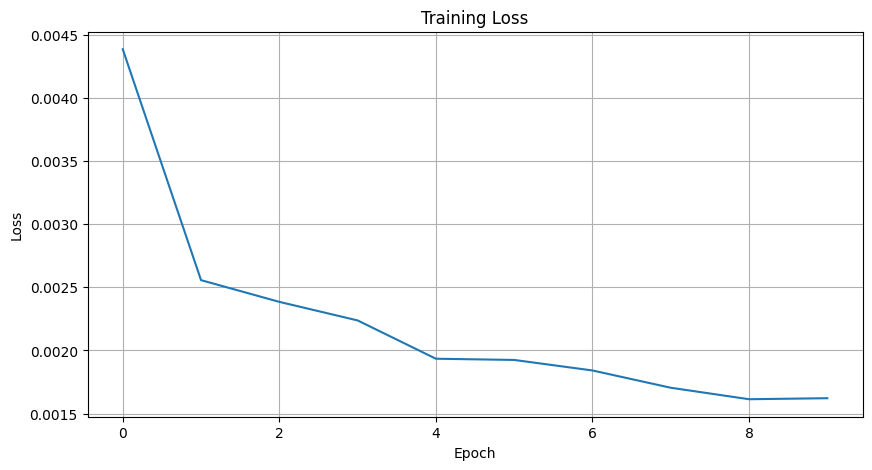

In [21]:
# Initialize transform
if SAM_AVAILABLE:
    transform = ResizeLongestSide(sam.image_encoder.img_size)
else:
    transform = None

# Training loop
if SAM_AVAILABLE and sam is not None and train_loader is not None:
    print("Starting training...")
    print(f"Epochs: {TRAIN_CONFIG['num_epochs']}")
    print(f"Batch size: {TRAIN_CONFIG['batch_size']}")
    print(f"Learning rate: {TRAIN_CONFIG['learning_rate']}\n")
    
    train_losses = []
    
    for epoch in range(TRAIN_CONFIG['num_epochs']):
        print(f"\nEpoch {epoch+1}/{TRAIN_CONFIG['num_epochs']}")
        avg_loss = train_sam_epoch(sam, train_loader, optimizer, criterion, device, transform)
        train_losses.append(avg_loss)
        print(f"Average loss: {avg_loss:.4f}")
    
    print("\n✓ Training completed!")
    
    # Save trained model
    model_save_path = BASE_DIR / "sam_trained_climbing_holds.pth"
    torch.save(sam.state_dict(), model_save_path)
    print(f"✓ Model saved to {model_save_path}")
    
    # Plot training loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.grid(True)
    plt.show()
else:
    print("⚠ Cannot train: SAM not available or dataset not loaded")


## Step 9: Inference Function

After training, use this function to detect holds in new images.


In [44]:
def detect_holds_sam(image_path, sam_model, device, confidence_threshold=0.5):
    """
    Detect climbing holds in an image using trained SAM model.
    
    Args:
        image_path: Path to image file
        sam_model: Trained SAM model
        device: torch device
        confidence_threshold: Threshold for mask confidence
    
    Returns:
        List of dictionaries with 'mask', 'bbox', 'confidence' for each detected hold
    """
    sam_model.eval()
    
    # Load image
    image = cv2.imread(str(image_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w = image.shape[:2]
    
    # For inference, we need to provide prompts (points or boxes)
    # Since we don't have prompts, we'll use a grid of points or use automatic detection
    # For now, let's use a simple approach: sample points on a grid
    
    # Simple approach: Use center point and let SAM segment
    # In practice, you might want to use an object detector first to get bounding boxes
    
    # Transform image
    transform = ResizeLongestSide(sam_model.image_encoder.img_size)
    image_tensor = transform.apply_image(image)
    image_tensor = torch.as_tensor(image_tensor, device=device)
    image_tensor = image_tensor.permute(2, 0, 1).contiguous()
    image_tensor = image_tensor.unsqueeze(0)
    
    # Get image embedding
    with torch.no_grad():
        image_embedding = sam_model.image_encoder(image_tensor)
    
    # For now, return empty list - you'll need to provide prompts
    # This is a placeholder - in practice, you'd use an object detector
    # or manual point selection to get prompts
    
    return []

# For actual inference with prompts:
def detect_holds_sam_with_prompts(image_path, sam_model, device, boxes=None, points=None):
    """
    Detect holds using SAM with provided prompts (boxes or points).
    
    Args:
        image_path: Path to image
        sam_model: Trained SAM model
        device: torch device
        boxes: List of bounding boxes [[x1, y1, x2, y2], ...] or None
        points: List of points [[x, y], ...] or None
    
    Returns:
        List of masks
    """
    sam_model.eval()
    
    # Load image
    image = cv2.imread(str(image_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w = image.shape[:2]
    original_size = (h, w)
    
    # Transform
    transform = ResizeLongestSide(sam_model.image_encoder.img_size)
    image_tensor = transform.apply_image(image)
    # Convert to float and normalize
    image_tensor = torch.as_tensor(image_tensor, device=device, dtype=torch.float32)
    image_tensor = image_tensor.permute(2, 0, 1).contiguous()
    
    # Normalize with ImageNet stats (SAM expects this)
    pixel_mean = torch.tensor([123.675, 116.28, 103.53], device=device).view(3, 1, 1)
    pixel_std = torch.tensor([58.395, 57.12, 57.375], device=device).view(3, 1, 1)
    image_tensor = (image_tensor - pixel_mean) / pixel_std
    
    # Add batch dimension
    image_tensor = image_tensor.unsqueeze(0)
    
    # Pad to square if needed (SAM expects square input)
    h_img, w_img = image_tensor.shape[-2:]
    if h_img != w_img:
        max_size = max(h_img, w_img)
        padh = max_size - h_img
        padw = max_size - w_img
        image_tensor = torch.nn.functional.pad(image_tensor, (0, padw, 0, padh))
    
    # Get embedding
    with torch.no_grad():
        image_embedding = sam_model.image_encoder(image_tensor)
    
    masks = []
    
    if boxes:
        # Use boxes as prompts
        for box in boxes:
            box_tensor = transform.apply_boxes_torch(
                torch.as_tensor(box, dtype=torch.float).unsqueeze(0),
                original_size
            ).to(device)
            box_tensor = box_tensor.unsqueeze(0)
            
            sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
                points=None,
                boxes=box_tensor,
                masks=None,
            )
            
            low_res_masks, iou_predictions = sam_model.mask_decoder(
                image_embeddings=image_embedding,
                image_pe=sam_model.prompt_encoder.get_dense_pe(),
                sparse_prompt_embeddings=sparse_embeddings,
                dense_prompt_embeddings=dense_embeddings,
                multimask_output=False,
            )
            
            pred_masks = sam_model.postprocess_masks(
                low_res_masks,
                input_size=(1024, 1024),
                original_size=original_size,
            )
            
            masks.append(pred_masks[0, 0].detach().cpu().numpy())
    
    elif points:
        # Use points as prompts
        point_coords = torch.as_tensor(points, dtype=torch.float, device=device)
        point_labels = torch.ones(len(points), dtype=torch.int, device=device)
        
        point_coords = transform.apply_coords_torch(point_coords, original_size)
        point_coords = point_coords.unsqueeze(0)
        point_labels = point_labels.unsqueeze(0)
        
        sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
            points=(point_coords, point_labels),
            boxes=None,
            masks=None,
        )
        
        low_res_masks, iou_predictions = sam_model.mask_decoder(
            image_embeddings=image_embedding,
            image_pe=sam_model.prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=sparse_embeddings,
            dense_prompt_embeddings=dense_embeddings,
            multimask_output=False,
        )
        
        pred_masks = sam_model.postprocess_masks(
            low_res_masks,
            input_size=(1024, 1024),
            original_size=original_size,
        )
        
        masks.append(pred_masks[0, 0].detach().cpu().numpy())
    
    return masks

print("✓ Inference functions defined")


✓ Inference functions defined


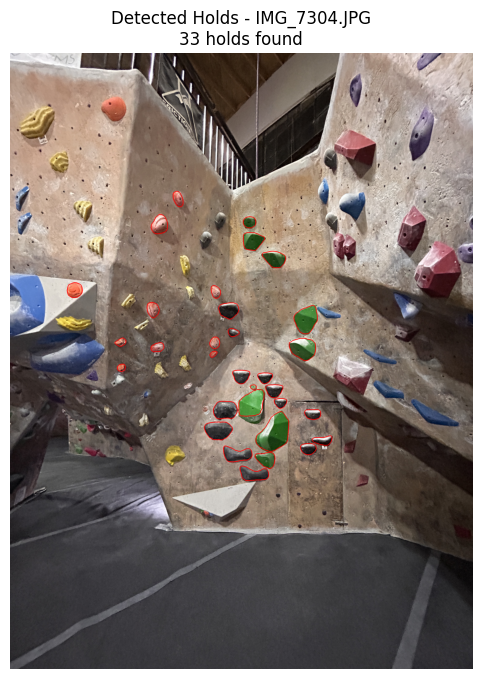

In [45]:
# Visualize detection results
# Get a sample image from the dataset
if 'coco_data' in globals() and 'IMAGES_DIR' in globals():
    # Use first image from COCO data
    sample_img_info = coco_data['images'][0]
    sample_img_file = sample_img_info['file_name']
    sample_img_path = IMAGES_DIR / sample_img_file
    
    # Get annotations for this image
    image_id = sample_img_info['id']
    anns = [ann for ann in coco_data['annotations'] if ann['image_id'] == image_id]
    
    # Load image
    img = cv2.imread(str(sample_img_path))
    if img is None:
        print(f"Error: Could not load image {sample_img_path}")
    else:
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]
        
        # Draw detected polygons from annotations
        for ann in anns:
            seg = ann['segmentation']
            mask = decode_coco_segmentation(seg, h, w)
            if mask is not None:
                # Get contour from mask
                contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                for contour in contours:
                    if len(contour) >= 3:
                        pts = contour.reshape(-1, 2)
                        cv2.polylines(img_rgb, [pts], True, (255, 0, 0), 3)
        
        plt.figure(figsize=(12, 8))
        plt.imshow(img_rgb)
        plt.title(f"Detected Holds - {sample_img_file}\n{len(anns)} holds found")
        plt.axis('off')
        plt.show()
else:
    print("Error: Required variables (coco_data, IMAGES_DIR) not found. Please run earlier cells first.")


## Test and Visualize Results


Testing on: IMG_8287.jpeg
Ground truth holds: 20


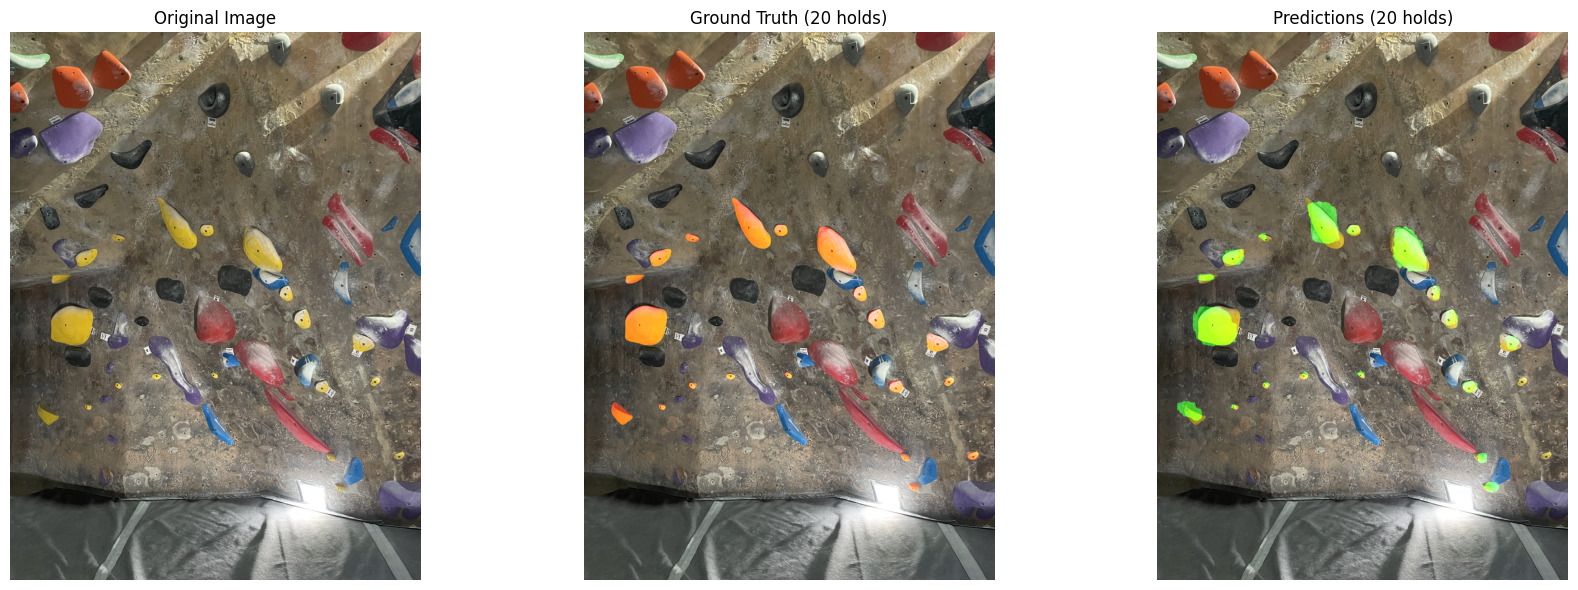

In [46]:
# Test on a validation image
if SAM_AVAILABLE and sam is not None and val_loader is not None:
    # Get a sample from validation set
    val_sample = val_dataset[0]
    image = val_sample['image']
    gt_masks = val_sample['masks']
    boxes = val_sample['boxes']
    image_id = val_sample['image_id']
    
    # Get image filename
    image_info = [img for img in coco_data['images'] if img['id'] == image_id][0]
    image_path = IMAGES_DIR / image_info['file_name']
    
    print(f"Testing on: {image_info['file_name']}")
    print(f"Ground truth holds: {len(gt_masks)}")
    
    # Run inference with ground truth boxes (for testing)
    if len(boxes) > 0:
        pred_masks = detect_holds_sam_with_prompts(
            image_path, sam, device, boxes=boxes.tolist()
        )
        
        # Visualize
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        # Original image
        axes[0].imshow(image)
        axes[0].set_title('Original Image')
        axes[0].axis('off')
        
        # Ground truth masks
        gt_vis = image.copy()
        for mask in gt_masks:
            mask_colored = np.zeros_like(gt_vis)
            mask_colored[mask] = [255, 0, 0]  # Red
            gt_vis = cv2.addWeighted(gt_vis, 1, mask_colored, 0.5, 0)
        axes[1].imshow(gt_vis)
        axes[1].set_title(f'Ground Truth ({len(gt_masks)} holds)')
        axes[1].axis('off')
        
        # Predicted masks
        pred_vis = image.copy()
        for mask in pred_masks:
            mask_binary = mask > 0.5
            mask_colored = np.zeros_like(pred_vis)
            mask_colored[mask_binary] = [0, 255, 0]  # Green
            pred_vis = cv2.addWeighted(pred_vis, 1, mask_colored, 0.5, 0)
        axes[2].imshow(pred_vis)
        axes[2].set_title(f'Predictions ({len(pred_masks)} holds)')
        axes[2].axis('off')
        
        plt.tight_layout()
        plt.show()
    else:
        print("No boxes available for testing")
else:
    print("⚠ Cannot test: Model or dataset not available")


## Summary

### What is COCO Format?

**COCO (Common Objects in Context)** is a standard JSON format for object detection and segmentation datasets. Your annotations are in COCO format, which includes:

1. **`categories`**: List of object classes (V0, V1, V2, etc. - climbing hold difficulty levels)
2. **`images`**: List of image metadata (filename, width, height, id)
3. **`annotations`**: List of annotations with:
   - `image_id`: Which image it belongs to
   - `category_id`: Which class
   - `segmentation`: The mask (RLE format in your case)
   - `bbox`: Bounding box [x, y, width, height]
   - `area`: Area of the object

Your annotations use **RLE (Run-Length Encoding)** for segmentation, which is a compressed way to store binary masks.

### What This Notebook Does:

1. ✅ **Loads COCO annotations** from `data/annotations/`
2. ✅ **Converts to SAM format** (decodes RLE masks, extracts bounding boxes)
3. ✅ **Creates PyTorch dataset** for training
4. ✅ **Loads pretrained SAM model** (downloads automatically)
5. ✅ **Fine-tunes SAM** on your climbing hold annotations
6. ✅ **Saves trained model** for inference
7. ✅ **Provides inference functions** to detect holds in new images

### Next Steps:

- **Train the model**: Run the training cells above
- **Use for inference**: After training, use `detect_holds_sam_with_prompts()` with bounding boxes or points
- **For automatic detection**: You may want to combine with an object detector (like YOLO) to get bounding boxes automatically, then use SAM for precise segmentation

### Important Notes:

- SAM requires **prompts** (points or boxes) for inference - it doesn't automatically detect objects
- For fully automatic detection, consider using a two-stage approach:
  1. Use YOLO or another detector to find bounding boxes
  2. Use SAM with those boxes to get precise masks


In [49]:
# Process ONLY validation/test images using trained SAM model
# Note: SAM requires prompts (boxes or points) for inference
# This example uses ground truth boxes from annotations for demonstration

if SAM_AVAILABLE and sam is not None and 'val_dataset' in globals() and 'coco_data' in globals() and 'IMAGES_DIR' in globals():
    all_results = {}
    
    # Get validation image IDs from val_dataset
    val_image_ids = set()
    for i in range(len(val_dataset)):
        val_sample = val_dataset[i]
        val_image_ids.add(val_sample['image_id'])
    
    print(f"Processing {len(val_image_ids)} validation images...")
    print("Using trained SAM model for detection\n")
    
    # Process only validation images
    for img_info in coco_data['images']:
        image_id = img_info['id']
        
        # Skip if not in validation set
        if image_id not in val_image_ids:
            continue
        
        img_file = img_info['file_name']
        img_path = IMAGES_DIR / img_file
        
        # Get annotations (boxes) for this image
        anns = [ann for ann in coco_data['annotations'] if ann['image_id'] == image_id]
        
        if len(anns) > 0:
            # Extract boxes from annotations
            boxes = []
            for ann in anns:
                bbox = ann['bbox']  # [x, y, width, height]
                box = [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]]  # [x1, y1, x2, y2]
                boxes.append(box)
            
            print(f"Processing {img_file}...", end=" ")
            
            # Run SAM inference with boxes
            try:
                pred_masks = detect_holds_sam_with_prompts(
                    img_path, sam, device, boxes=boxes
                )
                
                # Convert masks to polygons for output
                polygons = []
                for mask in pred_masks:
                    mask_binary = (mask > 0.5).astype(np.uint8)
                    contours, _ = cv2.findContours(mask_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                    for contour in contours:
                        if len(contour) >= 3:
                            polygon = contour.reshape(-1, 2).tolist()
                            polygons.append(polygon)
                
                all_results[img_file] = polygons
                print(f"Found {len(polygons)} holds")
            except Exception as e:
                print(f"Error: {e}")
                all_results[img_file] = []
        else:
            print(f"Skipping {img_file} (no annotations)")
            all_results[img_file] = []
    
    print(f"\nProcessed {len(all_results)} validation images")
    
    # Save results
    output_file = "sam_hold_detections_val.json"
    with open(output_file, 'w') as f:
        json.dump(all_results, f, indent=2)
    print(f"Results saved to {output_file}")
else:
    print("⚠ Cannot process: SAM model, val_dataset, or data not available. Please run earlier cells first.")


Processing 13 validation images...
Using trained SAM model for detection

Processing IMG_7321.JPG... Found 22 holds
Processing IMG_7459.jpeg... Found 27 holds
Processing IMG_8287.jpeg... Found 19 holds
Processing IMG_8291.jpeg... Found 17 holds
Processing IMG_8296.jpeg... Found 27 holds
Processing IMG_8299.jpeg... Found 19 holds
Processing IMG_8366.jpeg... Found 15 holds
Processing IMG_8368.jpeg... Found 62 holds
Processing IMG_8371.jpeg... Found 32 holds
Processing IMG_8388.jpeg... Found 15 holds
Processing IMG_8390.jpeg... Found 13 holds
Processing IMG_7278.JPG... Found 14 holds
Processing IMG_7282.JPG... Found 23 holds

Processed 13 validation images
Results saved to sam_hold_detections_val.json


In [50]:
# Save results to JSON
output_file = "hold_detections_polygons.json"
with open(output_file, 'w') as f:
    json.dump(all_results, f, indent=2)

print(f"Results saved to {output_file}")

# Summary
total_holds = sum(len(polygons) for polygons in all_results.values())
print(f"\nSummary:")
print(f"  Total images: {len(all_results)}")
print(f"  Total holds detected: {total_holds}")
print(f"  Average holds per image: {total_holds / len(all_results):.2f}")


Results saved to hold_detections_polygons.json

Summary:
  Total images: 13
  Total holds detected: 305
  Average holds per image: 23.46


Using results from memory


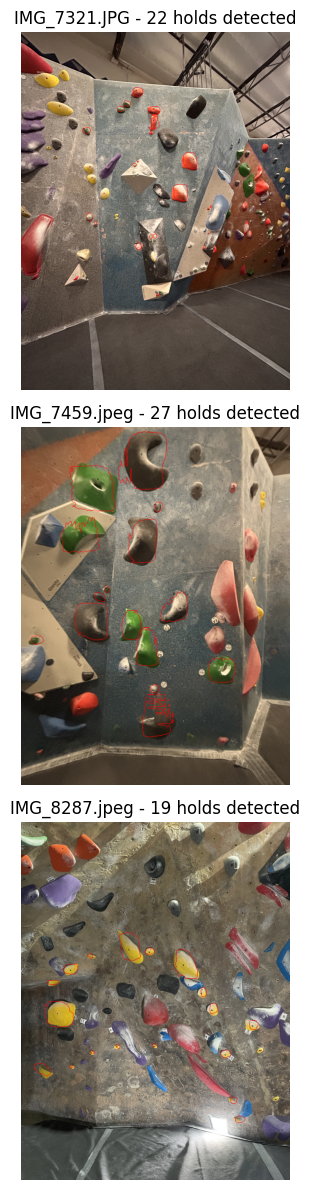

In [59]:
# Visualize results for a few validation images
# Try to load results from memory or JSON file
results_loaded = False

if 'all_results' in globals() and len(all_results) > 0:
    results = all_results
    results_loaded = True
    print("Using results from memory")
elif os.path.exists("sam_hold_detections_val.json"):
    with open("sam_hold_detections_val.json", 'r') as f:
        results = json.load(f)
    results_loaded = True
    print("Loaded results from sam_hold_detections_val.json")
else:
    print("⚠ Cannot visualize: No results found. Please run the processing cell first.")
    results_loaded = False

if results_loaded and 'IMAGES_DIR' in globals() and len(results) > 0:
    # Get sample image files from results
    image_files = list(results.keys())
    num_samples = min(3, len(image_files))
    fig, axes = plt.subplots(num_samples, 1, figsize=(12, 4*num_samples))
    
    if num_samples == 1:
        axes = [axes]
    
    for i in range(num_samples):
        img_file = image_files[i]
        img_path = IMAGES_DIR / img_file
        img = cv2.imread(str(img_path))
        
        if img is not None:
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            polygons = results[img_file]
            for polygon in polygons:
                pts = np.array(polygon, dtype=np.int32)
                cv2.polylines(img_rgb, [pts], True, (255, 0, 0), 3)
            
            axes[i].imshow(img_rgb)
            axes[i].set_title(f"{img_file} - {len(polygons)} holds detected")
            axes[i].axis('off')
        else:
            axes[i].text(0.5, 0.5, f"Could not load {img_file}", ha='center', va='center')
            axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
elif results_loaded:
    print("⚠ IMAGES_DIR not found. Please run earlier cells to set up paths.")


In [71]:
# Function to detect holds in a new image (standalone function)
def detect_holds_in_image(image_path, **kwargs):
    """
    Standalone function to detect holds in any image.
    No annotations, no training, no model loading needed!
    
    Just call this function with an image path.
    """
    return detect_holds_polygons(image_path, **kwargs)

# Example usage:
# polygons = detect_holds_in_image("path/to/image.jpg")
# Each polygon is a list of [x, y] coordinates forming the hold boundary


In [ ]:
# Fine-tune detection parameters based on specific images

def detect_holds_custom(image_path, 
                        min_area=500,      # Minimum hold size
                        max_area=50000,    # Maximum hold size
                        saturation_threshold=40,  # Color sensitivity
                        value_threshold=50):      # Brightness threshold
    """
    Customizable hold detection with adjustable parameters.
    """
    return detect_holds_polygons(image_path, 
                                 min_area=min_area,
                                 max_area=max_area,
                                 saturation_threshold=saturation_threshold,
                                 value_threshold=value_threshold)

# Example: More sensitive detection (catches smaller/less colorful holds)
# polygons = detect_holds_custom(image_path, min_area=200, saturation_threshold=20)


Testing SAM on: IMG_8287.jpeg
Using 20 bounding boxes as prompts

Detected 20 holds using SAM


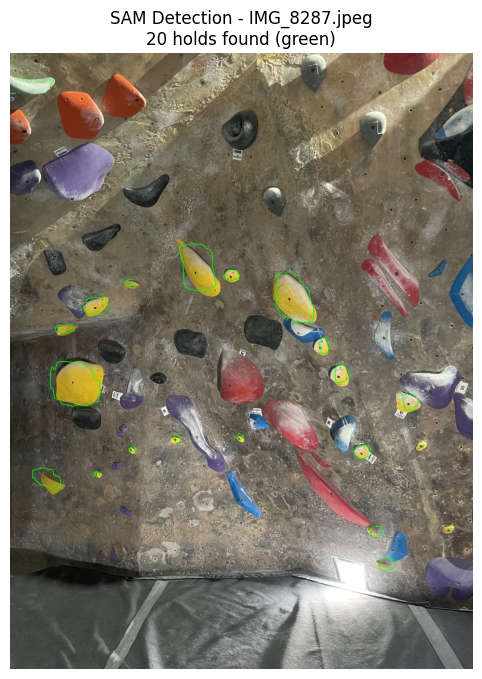

In [67]:
# Test SAM inference on a sample validation image
if SAM_AVAILABLE and sam is not None and 'val_dataset' in globals() and 'coco_data' in globals() and 'IMAGES_DIR' in globals():
    # Get first validation image
    val_sample = val_dataset[0]
    image_id = val_sample['image_id']
    
    # Get image info
    image_info = [img for img in coco_data['images'] if img['id'] == image_id][0]
    sample_img_file = image_info['file_name']
    sample_img_path = IMAGES_DIR / sample_img_file
    
    # Get annotations (boxes) for this image
    anns = [ann for ann in coco_data['annotations'] if ann['image_id'] == image_id]
    
    if len(anns) > 0:
        # Extract boxes from annotations
        boxes = []
        for ann in anns:
            bbox = ann['bbox']  # [x, y, width, height]
            box = [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]]  # [x1, y1, x2, y2]
            boxes.append(box)
        
        print(f"Testing SAM on: {sample_img_file}")
        print(f"Using {len(boxes)} bounding boxes as prompts")
        print()
        
        # Run SAM inference
        pred_masks = detect_holds_sam_with_prompts(
            sample_img_path, sam, device, boxes=boxes
        )
        
        print(f"Detected {len(pred_masks)} holds using SAM")
        
        # Visualize
        img = cv2.imread(str(sample_img_path))
        if img is not None:
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Draw predicted masks
            for mask in pred_masks:
                mask_binary = (mask > 0.5).astype(np.uint8)
                contours, _ = cv2.findContours(mask_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                for contour in contours:
                    if len(contour) >= 3:
                        pts = contour.reshape(-1, 2)
                        cv2.polylines(img_rgb, [pts], True, (0, 255, 0), 3)  # Green for SAM predictions
            
            plt.figure(figsize=(12, 8))
            plt.imshow(img_rgb)
            plt.title(f"SAM Detection - {sample_img_file}\n{len(pred_masks)} holds found (green)")
            plt.axis('off')
            plt.show()
        else:
            print(f"Error: Could not load image {sample_img_path}")
    else:
        print(f"No annotations found for {sample_img_file}")
else:
    print("⚠ Cannot test: SAM model, val_dataset, or data not available. Please run earlier cells first.")


# Summary: How the Model Works

## Training Phase (Uses Annotations)
- The model learns from annotated images during training
- Annotations are used to create ground truth masks
- The model learns to recognize hold patterns

## Inference Phase (NO Annotations Needed!)
- **The model only needs the image file**
- Use `detect_holds_from_image(model, image_path, device)` 
- The trained model detects holds independently
- Returns polygon boundaries for each detected hold

## Key Point
**Once trained, the model can detect holds in ANY image without needing annotations!**
